In [1]:
%matplotlib inline

In [2]:
import numpy as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
iris = pd.read_csv('data.csv')

In [4]:
iris.shape

(429, 7)

In [5]:
iris.head()

,MarksSimilarity,VisualSimilarity,AuralSimilarity,ConceptualSimilarity,G&SSimilarity,LikelyhoodOfConfusion,WinOrLose
0,6.0,3.0,9.0,5.0,6.0,7.0,1
1,6.0,7.0,8.0,7.0,7.0,7.0,1
2,10.0,10.0,10.0,10.0,8.0,9.0,1
3,3.0,3.0,6.0,3.0,3.0,-1.0,0
4,10.0,10.0,10.0,10.0,7.0,8.0,1


In [6]:
iris = iris.sort_values(by=['WinOrLose'])

In [7]:
iris.head()

,MarksSimilarity,VisualSimilarity,AuralSimilarity,ConceptualSimilarity,G&SSimilarity,LikelyhoodOfConfusion,WinOrLose
214,5.453301,6.000000,2.00000,2.0,-1.00000,2.0,0
271,3.000000,3.000000,3.87839,3.0,-1.00000,-1.0,0
269,5.000000,7.796106,3.00000,4.0,7.00000,2.0,0
268,2.000000,3.000000,2.00000,2.0,-0.38164,-1.0,0
267,3.705031,5.000000,6.00000,2.0,6.00000,2.0,0


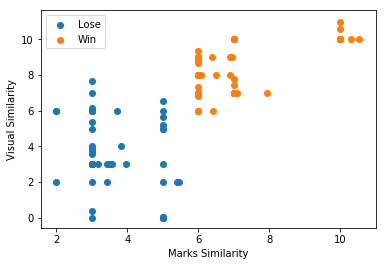

In [11]:
plt.scatter(iris[:60].MarksSimilarity, iris[:60].AuralSimilarity, label='Lose')
plt.scatter(iris[-60:].MarksSimilarity, iris[-60:].AuralSimilarity, label='Win')
plt.xlabel('Marks Similarity')
plt.ylabel('Visual Similarity')
plt.legend(loc='best')

In [12]:
X = iris.drop(labels=['WinOrLose'], axis=1).values
Y = iris.WinOrLose.values

In [13]:
# set seed for numpy and tensorflow
# set for reproducible results
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

In [14]:
# set replace=False, Avoid double sampling
trainIndex = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

In [15]:
# diff set
testIndex = np.array(list(set(range(len(X))) - set(trainIndex)))
trainX = X[trainIndex]
trainY = Y[trainIndex]
testX = X[testIndex]
testY = Y[testIndex]

In [16]:
# Use the min max normalization to map the the X 
def min_max_normalized(data):
    colMax = np.max(data, axis=0)
    colMin = np.min(data, axis=0)
    return np.divide(data - colMin, colMax - colMin)

In [17]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
trainX = min_max_normalized(trainX)
testX = min_max_normalized(testX)

In [18]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 6 features here, A's dimension is (6, 1)
W = tf.Variable(tf.random_normal(shape=[6, 1]), name='W')
b = tf.Variable(tf.random_normal(shape=[1, 1]), name= 'b')
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [19]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 6])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [20]:
# Declare the model you need to learn
model = tf.matmul(data, W) + b

In [21]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=target))

In [22]:
# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 40
iter_num = 10000

In [23]:
# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [24]:
# Define the goal
goal = optimizer.minimize(loss)

In [25]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(model))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [26]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [27]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batchIndex = np.random.choice(len(trainX), size=batch_size)
    batchTrainX = trainX[batchIndex]
    batchTrainY = np.matrix(trainY[batchIndex]).T
    sess.run(goal, feed_dict={data: batchTrainX, target: batchTrainY})
    temp_loss = sess.run(loss, feed_dict={data: batchTrainX, target: batchTrainY})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: trainX, target: np.matrix(trainY).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: testX, target: np.matrix(testY).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.961202 train_acc: 0.571429 test_acc: 0.569767
epoch:  600 loss: 0.752584 train_acc: 0.594752 test_acc: 0.604651
epoch:  900 loss: 0.782408 train_acc: 0.612245 test_acc: 0.627907
epoch: 1200 loss: 0.765252 train_acc: 0.644315 test_acc: 0.662791
epoch: 1500 loss: 0.658927 train_acc: 0.699708 test_acc: 0.709302
epoch: 1800 loss: 0.724388 train_acc: 0.740525 test_acc: 0.755814
epoch: 2100 loss: 0.579998 train_acc: 0.740525 test_acc: 0.755814
epoch: 2400 loss: 0.667079 train_acc: 0.740525 test_acc: 0.755814
epoch: 2700 loss: 0.595046 train_acc: 0.740525 test_acc: 0.755814
epoch: 3000 loss: 0.574836 train_acc: 0.740525 test_acc: 0.755814
epoch: 3300 loss: 0.545524 train_acc: 0.743440 test_acc: 0.755814
epoch: 3600 loss: 0.545159 train_acc: 0.746356 test_acc: 0.767442
epoch: 3900 loss: 0.486734 train_acc: 0.766764 test_acc: 0.779070
epoch: 4200 loss: 0.529896 train_acc: 0.769679 test_acc: 0.790698
epoch: 4500 loss: 0.473097 train_acc: 0.795918 test_acc: 0.813953
epoch: 480

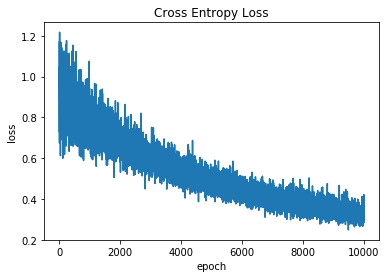

In [28]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

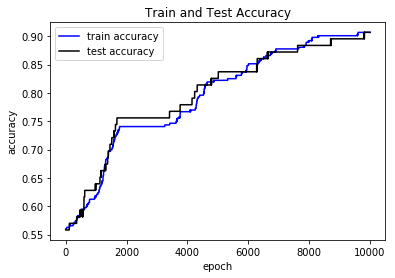

In [29]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [30]:
# vars = tf.trainable_variables()
# vars_vals = sess.run(vars)
# for var, val in zip(vars, vars_vals):
#    print("var: {}, value: {}".format(var.name, val))

In [31]:
sess.run(W)

array([[-0.08570787],
       [ 0.52814084],
       [ 1.5258981 ],
       [ 1.693391  ],
       [-0.34702238],
       [ 0.6054591 ]], dtype=float32)

In [ ]:
sess.run(b)